<a id='top'></a>

### 0_methods_B_tuning_4_analyse.ipynb  

# Tuning: analyse
This notebook analyses the tuning runs and determines the best-fit parameters (ws, kdes, sigmas). For this we use the information on tuning runs and computed MAE, RMSE, median and MRT, which was written into a csv in tuning_find_best_fit.ipynb.  

Different ensembles are used per figure:
- for tuning step 1, Kdes (Fig. 4): ensemble 'KDE'
- for tuning step 2, Ws (Fig. S2): ensemble '2TU'
- for tuning step 3, all sigmas (Fig. S3-S4): ensemble '3P5'

Steps: 
- [Set up notebook](#setup-notebook)
- [Load observations dissolved](#load-obs)
- [Load observations particle-bound](#load-obs-part)
- [Analysis:](#analyse)
  - [Explore MAEs](#explore)
  - [Fig. 4: determine best sinking speed w_s](#ws)
  - [Fig. S2: determine best k_des](#kdes)
  - [Fig. S3, S4: determine best sigmas](#all)


### TODO cleanup the input excels met MAEs  
(and make the columns identical including PaThWs; see TODO lower)

<a id='setup-notebook'></a>
# Set up notebook
[go to top](#top)

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [17]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################

# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here

## OR define modeldir depending on which system you are working on:
# if platform.system() == "Darwin":   # on Mac (e.g. laptop)
#    modeldir = Path('~/Documents/PHD/Bern3D/results')
# elif platform.system() == "Linux":  # on linux (e.g. cluster)
#    modeldir = Path('/storage/climatestor/Bern3dLPX/scheen/b3d_results')
# else:
#    raise Exception("unknown system", platform.system())

#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# set a random run (the 1st run actually) as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / '1TU1000_PI'  

# in the model output, simulation year 0 is called 1765 CE (pre-industrial)
spinup_yr = 1765

## INFORMATION ON ENSEMBLES
# only used for ensemble 'KDE':
kdes_runs_batch1 = list(range(0,20))+list(range(40,48))
kdes_runs_batch2 = list(range(20,40))+list(range(48,56))
kdes_runs_batch3 = list(range(56,84))
kdes_runs_all = kdes_runs_batch1+kdes_runs_batch2+kdes_runs_batch3

# list member numbers per ensemble
all_run_nrs = {'KDE' : kdes_runs_all,     # for tuning step 1: Kdes (Fig. 4)
               '2TU' : range(0,511),      # for tuning step 2: Ws (Fig. S2)
               '3P5' : range(0,3000)}     # for tuning step 3: all sigmas (Fig. S3-S4)

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [2]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

<a id='load-obs'></a>
# Load observations of dissolved Pa, Th
IDP 2021 = Intermediate Data Product  
see obsdir/IDP_2021_log_how_downloaded.rtf  
[go to top](#top)

In [3]:
# load geotraces observations
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')
obs_d_incl_arctic = pd.concat([obs_d_geotraces_incl_arctic,obs_d_deng,obs_d_ng
                               ,obs_d_pavia], join='outer')  # for completeness; not used

[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:692: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


In [4]:
## define basins/cruises of interest
# using obs_d since obs_p would only give a subset of that
cruises_all = np.unique(obs_d.cruise)                      # already excludes Arctic cruises

# only 1 basin incl its SO sector
cruises_Atl = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10','GIPY04', 'GIPY05', 
               'deng', 'ng'] # deng=geovide
cruises_Pac = ['GP16', 'GPc01', 'GSc02', 'pavia']

# SO (Southern Ocean)
cruises_SO = ['GSc02','GIPY04', 'GIPY05','GIpr05', 'pavia'] 
# chosing here the definition that GA10 is not SO

# for testing purposes; not used
cruises_Arctic = ['GN01', 'GN02', 'GN03', 'GN04']  
cruises_Labr = ['GN02']

<a id='load-obs-part'></a>
# Load observations of particle-bound Pa, Th
IDP 2021 = Intermediate Data Product  
see obsdir/IDP_2021_log_how_downloaded.rtf  
[go to top](#top)

In [5]:
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'

obs_p_incl_arctic = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
obs_p = obs_p_incl_arctic[~obs_p_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)

Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


**Prepare plotting gadgets**

In [6]:
# SD of observations, to be able to normalize by it, as in Rempfer et al. 2017 Fig. 1

# save and print average and SD of observations:
print('Before averaging observations that lie in the same grid cell:')
SD_obs = {'Pad' : np.round(obs_d.Pad.std(),3), 'Thd' : np.round(obs_d.Thd.std(),3), 
          'Pap' : np.round(obs_p.Pap.std(),3), 'Thp' : np.round(obs_p.Thp.std(),3)}
ave_obs = {'Pad' : np.round(obs_d.Pad.mean(),3), 'Thd' : np.round(obs_d.Thd.mean(),3), 
          'Pap' : np.round(obs_p.Pap.mean(),3), 'Thp' : np.round(obs_p.Thp.mean(),3)}
print('Pad obs have average', ave_obs['Pad'], 'uBq/kg with  SD=sigma=', SD_obs['Pad'], 'uBq/kg.')
print('Thd obs have average', ave_obs['Thd'], 'uBq/kg with SD=sigma=', SD_obs['Thd'], 'uBq/kg.')
print('Pap obs have average', ave_obs['Pap'], 'uBq/kg with  SD=sigma=', SD_obs['Pap'], 'uBq/kg.')
print('Thp obs have average', ave_obs['Thp'], 'uBq/kg with SD=sigma=', SD_obs['Thp'], 'uBq/kg.\n')

print('After averaging observations that lie in the same grid cell:')
print('Pad obs_ave have average', np.round(obs_d_ave.Pad.mean(),3), 'uBq/kg with  SD=sigma=', np.round(obs_d_ave.Pad.std(),3), 'uBq/kg.')
print('Thd obs_ave have average', np.round(obs_d_ave.Thd.mean(),3), 'uBq/kg with  SD=sigma=', np.round(obs_d_ave.Thd.std(),3), 'uBq/kg.')
print('Pap obs_ave have average', np.round(obs_p_ave.Pap.mean(),3), 'uBq/kg with  SD=sigma=', np.round(obs_p_ave.Pap.std(),3), 'uBq/kg.')
print('Thp obs_ave have average', np.round(obs_p_ave.Thp.mean(),3), 'uBq/kg with  SD=sigma=', np.round(obs_p_ave.Thp.std(),3), 'uBq/kg.')

# save median of observations:
median_obs = {'Pad' : obs_d.Pad.median(), 'Thd' : obs_d.Thd.median(), 'Pap' : obs_p.Pap.median(), 'Thp' : obs_p.Thp.median()}

# enter observational range of sigmas, to be able to make it a grey rectangle in plots
bnd_sigma_pa_poc = [0.003, 0.02]
bnd_sigma_pa_ca = [0.001, 0.23]
bnd_sigma_pa_op = [0.002, 0.22]
bnd_sigma_pa_du = [0.00001, 0.0044]
bnd_sigma_pa_ne = [0.0005, 0.028]
bnd_sigma_th_poc = [0.028, 0.14]
bnd_sigma_th_ca = [0.019, 7.93]
bnd_sigma_th_op = [0.006, 0.2]
bnd_sigma_th_du = [0.00009, 0.0044]
bnd_sigma_th_ne = [0.0028, 0.054]
bnd_k_des_th = [1.0, 3.0]  # based on Luo et al. 2010 OS for k_des^Th; for Pa they say even less constraint (we take no Pa constraints)

Before averaging observations that lie in the same grid cell:
Pad obs have average 3.392 uBq/kg with  SD=sigma= 2.284 uBq/kg.
Thd obs have average 6.939 uBq/kg with SD=sigma= 5.554 uBq/kg.
Pap obs have average 0.086 uBq/kg with  SD=sigma= 0.238 uBq/kg.
Thp obs have average 1.572 uBq/kg with SD=sigma= 6.549 uBq/kg.

After averaging observations that lie in the same grid cell:
Pad obs_ave have average 3.475 uBq/kg with  SD=sigma= 2.396 uBq/kg.
Thd obs_ave have average 7.282 uBq/kg with  SD=sigma= 5.825 uBq/kg.
Pap obs_ave have average 0.059 uBq/kg with  SD=sigma= 0.067 uBq/kg.
Thp obs_ave have average 0.996 uBq/kg with  SD=sigma= 1.383 uBq/kg.


In [7]:
## determine 0 levels: 
# print RMSE and MAE if all model output would be 0

###### SETTINGS ####################
# RMSE_tasks = {'RMSE_tot_weights':(cruises_all,False,True,True), 
#               'RMSE_vol_weights':(cruises_all,False,True,False), 
#               'RMSE_unc_weights':(cruises_all,False,False,True), 
#               'RMSE_no_weights':(cruises_all,False,False,False), 
#               'RMSE_incl_arctic_tot_weights':(cruises_incl_arctic,False,True,True), 
#               'RMSE_incl_arctic_vol_weights':(cruises_incl_arctic,False,True,False),
#               'RMSE_incl_arctic_unc_weights':(cruises_incl_arctic,False,False,True), 
#               'RMSE_incl_arctic_no_weights':(cruises_incl_arctic,False,False,False)}

RMSE_tasks = {'RMSE_unc_weights':(cruises_all,False,False,True)}

# MAE_tasks are hardcoded below to be exactly the same but with keys 'MAE___' instead of 'RMSE___'
####################################

# set example run; only used for grid
fnctrl_wo_path = str(fnctrl).split('/')[-1]
    
RMSE0s = {}
MAE0s = {}
for key in RMSE_tasks:
    (cruises, wo_surface, weighted_vol, weighted_unc) = RMSE_tasks[key]    
    [junk, this_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [junk, this_obs_p_ave, junk2] = f.subset_of_obs(obs_p, fnctrl, cruises=cruises, wo_surface=wo_surface)
    # calculation of RMSE if 0
    [res_d_table, res_entire] = f.get_sim(memberid=fnctrl_wo_path, path=modeldir, ensemble='FREE', 
                                          obs_ave=this_obs_d_ave, convert_unit_to_obs=True)
    [res_p_table, res_entire] = f.get_sim(memberid=fnctrl_wo_path, path=modeldir, ensemble='FREE', 
                                          obs_ave=this_obs_p_ave, convert_unit_to_obs=True)
    if weighted_vol or weighted_unc:
        [weights_Pad, weights_Thd] = f.find_weights(this_obs_d_ave, res_entire, volume=weighted_vol, uncertainty=weighted_unc) 
        [weights_Pap, weights_Thp] = f.find_weights(this_obs_p_ave, res_entire, volume=weighted_vol, uncertainty=weighted_unc) 
    else: 
        weights_Pad = None
        weights_Thd = None
        weights_Pap = None
        weights_Thp = None        
    res_d_table.loc[:,:] = 0.0
    res_p_table.loc[:,:] = 0.0
    this_RMSE0_Pad = f.calc_rmse(model=res_d_table.Pad, observation=this_obs_d_ave.Pad, 
                                 weights=weights_Pad, verbose=False)
    this_RMSE0_Thd = f.calc_rmse(model=res_d_table.Thd, observation=this_obs_d_ave.Thd, 
                                 weights=weights_Thd, verbose=False)
    this_RMSE0_Pap = f.calc_rmse(model=res_p_table.Pap, observation=this_obs_p_ave.Pap, 
                                 weights=weights_Pap, verbose=False)
    this_RMSE0_Thp = f.calc_rmse(model=res_p_table.Thp, observation=this_obs_p_ave.Thp, 
                                 weights=weights_Thp, verbose=False)
    RMSE0s[key] = {'Pad':this_RMSE0_Pad, 'Thd':this_RMSE0_Thd, 'Pap':this_RMSE0_Pap, 'Thp':this_RMSE0_Thp}
    
    # repeat calculation of MAE if 0 for exactly the same cases as RMSE_tasks
    this_MAE0_Pad = f.calc_mae(model=res_d_table.Pad, observation=this_obs_d_ave.Pad, 
                               weights=weights_Pad, verbose=False)
    this_MAE0_Thd = f.calc_mae(model=res_d_table.Thd, observation=this_obs_d_ave.Thd, 
                               weights=weights_Thd, verbose=False)
    this_MAE0_Pap = f.calc_mae(model=res_p_table.Pap, observation=this_obs_p_ave.Pap, 
                               weights=weights_Pap, verbose=False)
    this_MAE0_Thp = f.calc_mae(model=res_p_table.Thp, observation=this_obs_p_ave.Thp, 
                               weights=weights_Thp, verbose=False)
    MAE0s[key.replace('RMSE','MAE')] = {'Pad':this_MAE0_Pad, 'Thd':this_MAE0_Thd, 
                                        'Pap':this_MAE0_Pap, 'Thp':this_MAE0_Thp}

print("\nRMSE0s are saved in dict 'RMSE0s'. MAE0s are saved in dict 'MAE0s'.")

Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.

RMSE0s are saved in dict 'RMSE0s'. MAE0s are saved in dict 'MAE0s'.


In [8]:
MAE0s

{'MAE_unc_weights': {'Pad': 2.538640673177767,
  'Thd': 4.82930246391353,
  'Pap': 0.03262665489352145,
  'Thp': 0.5561279450915712}}

<a id='analyse'></a>
# Analysis
  - [Explore MAEs](#explore)
  - [Fig. 4: determine best sinking speed w_s](#ws)
  - [Fig. S2: determine best k_des](#kdes)
  - [Fig. S3, S4: determine best sigmas](#all)

[go to top](#top)

<a id='explore'></a>
## Explore total table with MAE values  

Set below for which ensemble you want to explore the MAE values.
- for tuning step 1, Kdes (Fig. 4): ensemble 'KDE'
- for tuning step 2, Ws (Fig. S2): ensemble '2TU'
- for tuning step 3, all sigmas (Fig. S3-S4): ensemble '3P5'  

[go to top](#top)

In [26]:
########### SETTINGS ###########################################
# For which ensemble do you want to explore the total table with MAEs?
ensemble = '2TU'  # choose from 'KDE' '2TU' '3P5'
################################################################

assert ensemble in ['KDE', '2TU', '3P5'], "invalid ensemble " + ensemble

# READ IN csv made in tuning_find_best_fit.ipynb FOR THIS ENSEMBLE
total_table = pd.read_csv(savedir / ('total_table_ensemble_' + ensemble + '.csv'))

In [10]:
total_table.columns

Index(['run_ID', 'runname', 'MRT_Pa', 'MRT_Th', 'median_Pad', 'median_Thd',
       'median_Pap', 'median_Thp', 'MAE_no_weights_Pad', 'MAE_no_weights_Thd',
       'MAE_no_weights_Pap', 'MAE_no_weights_Thp', 'MAE_tot_weights_Pad',
       'MAE_tot_weights_Thd', 'MAE_tot_weights_Pap', 'MAE_tot_weights_Thp',
       'MAE_vol_weights_Pad', 'MAE_vol_weights_Thd', 'MAE_vol_weights_Pap',
       'MAE_vol_weights_Thp', 'MAE_unc_weights_Pad', 'MAE_unc_weights_Thd',
       'MAE_unc_weights_Pap', 'MAE_unc_weights_Thp', 'RMSE_no_weights_Pad',
       'RMSE_no_weights_Thd', 'RMSE_no_weights_Pap', 'RMSE_no_weights_Thp',
       'RMSE_tot_weights_Pad', 'RMSE_tot_weights_Thd', 'RMSE_tot_weights_Pap',
       'RMSE_tot_weights_Thp', 'PaThWs', 'PaDesConst', 'ThDesConst',
       'sigmaPaPOC', 'sigmaPaCa', 'sigmaPaOp', 'sigmaPaDu', 'sigmaPaNeph',
       'sigmaThPOC', 'sigmaThCa', 'sigmaThOp', 'sigmaThDu', 'sigmaThNeph'],
      dtype='object')

In [11]:
# examples of subsets of table sorted by best values for variable on LHS

total_table.sort_values('MAE_unc_weights_Pad').loc[:,('MAE_unc_weights_Pad','median_Pad','PaThWs','sigmaPaPOC','sigmaPaCa','sigmaPaDu')]
# total_table.sort_values('RMSE_no_weights_Pad').loc[:,('RMSE_no_weights_Pad','median_Pad','PaThWs','sigmaPaPOC','sigmaPaCa','sigmaPaDu')]
# total_table.sort_values('MAE_no_weights_Pad').loc[:,('MAE_no_weights_Pad','median_Pad','PaThWs','sigmaPaPOC','sigmaPaCa','sigmaPaDu')]

,MAE_unc_weights_Pad,median_Pad,PaThWs,sigmaPaPOC,sigmaPaCa,sigmaPaDu
297,1.058151,2.110290,1840.738602,0.017035,0.066290,0.004770
438,1.068375,1.846967,2005.900385,0.015144,0.190526,0.003651
429,1.068519,2.035226,795.208450,0.016334,0.080771,0.004007
318,1.071104,1.752057,1347.245445,0.021509,0.074430,0.005229
185,1.098604,1.736852,2475.089863,0.003555,0.208728,0.001453
...,...,...,...,...,...,...
346,4.104630,7.854663,558.987191,0.010884,0.138000,0.017330
264,4.107984,7.624452,830.429046,0.014009,0.090255,0.011567
483,4.144937,8.203901,523.605139,0.010164,0.126273,0.013680
132,5.064608,8.782086,514.136728,0.014167,0.064656,0.009678


In [12]:
# examples of sorting by 1 of the sigmas or Ws (and showing 1 of the MAEs on the LHS)

total_table.sort_values('sigmaPaPOC').loc[:,('MAE_unc_weights_Pad','sigmaPaPOC','sigmaPaCa',
                                             'sigmaPaOp','sigmaPaDu','sigmaPaNeph','PaThWs')]
# total_table.sort_values('sigmaPaNeph').loc[:,('MAE_unc_weights_Pad','sigmaPaPOC','sigmaPaCa',
#                                               'sigmaPaOp','sigmaPaDu','sigmaPaNeph','PaThWs')]
# total_table.sort_values('PaThWs').loc[:,('MAE_unc_weights_Pad','sigmaPaPOC','sigmaPaCa',
#                                               'sigmaPaOp','sigmaPaDu','sigmaPaNeph','PaThWs')]

# TODO IF ERROR: if KeyError e.g. "PaThWs not in index": then for the chosen 
#                                                        ensemble this var is not available in total_table

,MAE_unc_weights_Pad,sigmaPaPOC,sigmaPaCa,sigmaPaOp,sigmaPaDu,sigmaPaNeph,PaThWs
186,1.708726,0.002809,0.175010,0.132868,0.008353,0.006386,3989.071555
445,1.876211,0.002827,0.127031,0.193328,0.025254,0.024653,4641.169324
8,1.462146,0.002859,0.136747,0.093048,0.006600,0.005111,2924.452943
121,1.875504,0.002906,0.131816,0.204258,0.026284,0.005376,4357.182753
208,1.350327,0.002921,0.230277,0.039960,0.022870,0.003011,2674.042586
...,...,...,...,...,...,...,...
279,1.410736,0.022180,0.067912,0.051093,0.013282,0.006174,2002.901930
229,1.639214,0.022182,0.091064,0.212088,0.011543,0.009862,2583.466733
189,1.480914,0.022244,0.055679,0.152911,0.015731,0.001033,4590.319589
230,1.411282,0.022330,0.129224,0.214694,0.004168,0.000284,2390.578433


<a id='ws'></a>
## Fig. 4: determine best sinking speed w_s   
## => uses ensemble '2TU'  
[go to top](#top)  

### combine Pap and Thp into 1 best Ws  
We combine them via
$$MAE_{p,tot} = \frac{MAE_{Pap}}{\overline{MAE_{Pap}}}+\frac{MAE_{Thp}}{\overline{MAE_{Thp}}}$$
where the bar indicates average over all runs of the ensemble under consideration. Analogously, we also combine the dissolved ones
$$MAE_{d,tot} = \frac{MAE_{Pad}}{\overline{MAE_{Pad}}}+\frac{MAE_{Thd}}{\overline{MAE_{Thd}}}$$
but we expect too much scatter there.  

Then we fit a function through them and determine the ws which minimizes the combined MAE. An alternative approach was directly determining the best MAE run without fitting a function, but this favoured outliers and thereby totally favoured Pap, due to its higher variance.

In [27]:
# READ IN csv made in tuning_find_best_fit.ipynb FOR THIS ENSEMBLE
ensemble = '2TU'  # do not change
total_table = pd.read_csv(savedir / ('total_table_ensemble_' + ensemble + '.csv'))

## PREPARATION: compute formula and add as column
######## SETTINGS ##########################
var_y = 'MAE_unc_weights'   # measure used in manuscript: MAE_unc_weights
############################################

MAE_ptot = total_table[var_y+'_Pap'] / total_table[var_y+'_Pap'].mean() + total_table[var_y+'_Thp'] / total_table[var_y+'_Thp'].mean()  
MAE_dtot = total_table[var_y+'_Pad'] / total_table[var_y+'_Pad'].mean() + total_table[var_y+'_Thd'] / total_table[var_y+'_Thd'].mean()  

total_table.insert(8,var_y+'_ptot',MAE_ptot)
total_table.insert(9,var_y+'_dtot',MAE_dtot)  # not used in final figure, for illustrative purposes.

FINAL RESULT: best Ws for Pap,Thp combination from fitted polynomial: 1598  m/yr

Best Ws for Pap from fitted polynomial: 2186  m/yr
Best Ws for Thp from fitted polynomial: 1084  m/yr


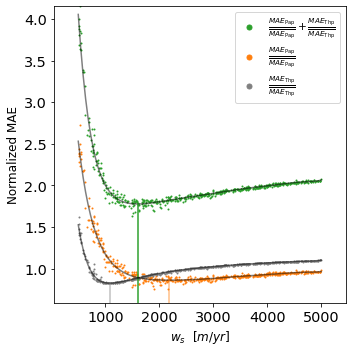

In [32]:
# show fitted function to Pap, Thp and their combination; print out the best ws i.e. that minimizes the result

######## SETTINGS ##########################
n = 10  # degree of polynomial
show_fitted_fnc = True
show_vert_lines = True  # only works if show_fitted_fnc
zoom = False
colours = {'Pad' : 'C0', 'Thd' : 'C2', 'Pap' : 'C1', 'Thp' : 'grey', 'PapThp' : 'C2'}

var_x = 'PaThWs'
var_y = 'MAE_unc_weights'
# can also select other var_x and var_y from total_table columns. Units and labels already listed:

units = {'PaThWs':'$[m/yr]$', 'XDesConst':'$[/yr]$', 'kads_sum_sigmas_x':'$[/yr]$', 'k_ads_x_sum':'$[/yr]$', 
         'sigmaXDu':'$[m^2/g~dust]$', 'sigmaXNeph':'$[m^2/g~neph]$', 'median':'$[\mu Bq/kg]$', 
         'MAE':'$[\mu Bq/kg]$', 'RMSE':'$[\mu Bq/kg]$', 'MAE_no_weights':'$[\mu Bq/kg]$',
         'MAE_tot_weights':'$[\mu Bq/kg]$', 'MAE_vol_weights':'$[\mu Bq/kg]$', 'MAE_unc_weights':'$[\mu Bq/kg]$'}
labels = {'PaThWs':'$w_s$', 'median':'median', 'MAE':'MAE', 'RMSE' : 'RMSE', 'MAE_no_weights' : 'MAE',
          'MAE_tot_weights':'MAE','MAE_unc_weights':'MAE','MAE_vol_weights':'MAE',
          'PaDesConst':'$k_{des}^{Pa}$', 'kads_sum_sigmas_pa':'$\sum_i \sigma_i^{Pa}$', 
          'k_ads_pa_sum':'$k_{ads,sum}^{Pa}$', 
          'sigmaPaDu':'$\sigma^{Pa}_{du}$', 'sigmaPaNeph':'$\sigma^{Pa}_{ne}$', 
          'ThDesConst':'$k_{des}^{Th}$', 'kads_sum_sigmas_th':'$\sum_i \sigma_i^{Th}$', 
          'k_ads_th_sum':'$k_{ads,sum}^{Th}$', 
          'sigmaThDu':'$\sigma^{Th}_{du}$', 'sigmaThNeph':'$\sigma^{Th}_{ne}$'}

############################################
assert ensemble == '2TU', "Needs ensemble '2TU' for this figure."

fig, ax = plt.subplots(1, figsize=(5,5))

# \dfrac is a bit larger than \frac
ax.scatter(total_table[var_x],total_table[var_y+'_ptot'], s=1, 
           label=r'$\frac{MAE_\mathrm{Pap}}{\overline{MAE_\mathrm{Pap}}} + \frac{MAE_\mathrm{Thp}}{\overline{MAE_\mathrm{Thp}}}$', 
           c=colours['PapThp'])  # is the sum i.e. entire formula (not halved here)
ax.scatter(total_table[var_x],total_table[var_y+'_Pap']/total_table[var_y+'_Pap'].mean(), s=1, 
           label=r'$\frac{MAE_\mathrm{Pap}}{\overline{MAE_\mathrm{Pap}}}$', c=colours['Pap'])  # is term 1 of formula above
ax.scatter(total_table[var_x],total_table[var_y+'_Thp']/total_table[var_y+'_Thp'].mean(), s=1, 
           label=r'$\frac{MAE_\mathrm{Thp}}{\overline{MAE_\mathrm{Thp}}}$', c=colours['Thp'])  # is term 2

if show_fitted_fnc:
    [ymin, ymax] = ax.get_ylim()
    x_new = np.linspace(500,5000,100)  # for plotting
    x_fine = range(0,5000,1)  # for print statement to find minimum: repeat with a finer grid (resolution 1m/yr)
    
    # combined
    polynomial_coeffs = np.polyfit(total_table[var_x], total_table[var_y+'_ptot'], n)
    fnc = np.poly1d(polynomial_coeffs)
    ax.plot(x_new, fnc(x_new), c='k', alpha=0.5)
    y_fine = fnc(x_fine)
    # now do not half (as in fnc)
    best_ws_papthp = x_fine[np.argmin(y_fine)]
    print('FINAL RESULT: best Ws for Pap,Thp combination from fitted polynomial:', best_ws_papthp, ' m/yr\n')
    if show_vert_lines:
        ax.plot([best_ws_papthp, best_ws_papthp],[ymin, y_fine.min()], c=colours['PapThp'], alpha=1.0)

    # Pap
    polynomial_coeffs = np.polyfit(total_table[var_x], total_table[var_y+'_Pap']/total_table[var_y+'_Pap'].mean(),
                                   n)   # in decreasing powers
    fnc = np.poly1d(polynomial_coeffs)  # in decreasing powers
    ax.plot(x_new, fnc(x_new), c='k', alpha=0.5)
    y_fine = fnc(x_fine)
    best_ws_pap = x_fine[np.argmin(y_fine)]
    print('Best Ws for Pap from fitted polynomial:', best_ws_pap, ' m/yr')
    if show_vert_lines:
        ax.plot([best_ws_pap, best_ws_pap],[ymin, y_fine.min()], c=colours['Pap'], alpha=0.5)

    # Thp
    polynomial_coeffs = np.polyfit(total_table[var_x], total_table[var_y+'_Thp']/total_table[var_y+'_Thp'].mean(),
                                   n)
    fnc = np.poly1d(polynomial_coeffs)
    ax.plot(x_new, fnc(x_new), c='k', alpha=0.5)
    y_fine = fnc(x_fine)
    best_ws_thp = x_fine[np.argmin(y_fine)]
    print('Best Ws for Thp from fitted polynomial:', best_ws_thp, ' m/yr')
    if show_vert_lines:
        ax.plot([best_ws_thp, best_ws_thp],[ymin, y_fine.min()], c=colours['Thp'], alpha=0.5)
    
ax.legend(markerscale=5, fontsize=10.5)
ax.set_xlabel(labels[var_x] + '  ' + units[var_x], fontsize=12)
ax.set_xticks(range(0,5500,1000))
ax.set_ylabel('Normalized MAE', fontsize=12)
ax.margins(0.1,0)

plt.tight_layout()
plt.savefig(savedir / ('fig4_' + ensemble + '_combined_' + var_y + '.pdf'))

### Conclusion: best Ws = 1598 m/yr = ca. 1600 m/yr
This final result is for the Pap,Thp combination; best for Pap: 2186 m/yr = ca. 2200 m/yr; for Thp: 1084 m/yr = ca. 1100 m/yr (based on n=10 and MAE_noArctic_unc_weights)  

For tuning Ws we did not use Pad and Thd but only Pap and Thp, because for the dissolved forms a lot of scatter is present. This is visible in the plot below, when comparing MAE(tot,d) in the upper panel with MAE(tot,p) in the lower panel. but only tot,p. Dissolved has more scatter because particle-bound forms sink thus have the direct dependence on ws, whereas dissolved forms are only affected via particle-bound and the conversion via scavenging. So the relationship of Pad, Thd with ws depends on the scavenging parameters (sigmas) of the particular run; and these were varied within the ensemble causing the scatter.

Direct printout of best run's w_s for Pad, Thd combined: 1000.0 m/yr, in run 2TU1250_PI
Direct printout of best run's w_s for Pap, Thp combined: 1503.8 m/yr, in run 2TU1464_PI 



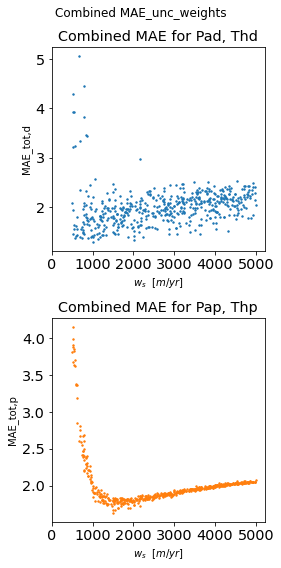

In [29]:
# plot also for dissolved to show scatter 

######## SETTINGS ##########################
var_y = 'MAE_unc_weights'

size = 2
colours = {'d' : 'C0', 'p' : 'C1'}
############################################
assert ensemble == '2TU', "Needs ensemble '2TU' for this figure."

fig, ax = plt.subplots(2,1, figsize=(4,8))

var_x = 'PaThWs'
fig.suptitle('Combined ' + var_y)
   
ax[0].set_title('Combined MAE for Pad, Thd')
ax[0].set_ylabel('MAE_tot,d')
cpf = ax[0].scatter(total_table[var_x], total_table[var_y+'_dtot'], s=size, c=colours['d'])
# print
y_obj = total_table.loc[:,('runname','PaThWs',var_y+'_dtot')]
res = y_obj[y_obj[var_y+'_dtot'] == y_obj[var_y+'_dtot'].min()].dropna(how='all')
print("Direct printout of best run's w_s for Pad, Thd combined:", np.round(res.PaThWs.item(),1), 'm/yr, in run',
      res.runname.item())

ax[1].set_title('Combined MAE for Pap, Thp')
ax[1].set_ylabel('MAE_tot,p')
cpf = ax[1].scatter(total_table[var_x], total_table[var_y+'_ptot'], s=size, c=colours['p'])
# print
y_obj = total_table.loc[:,('runname','PaThWs',var_y+'_ptot')]
res = y_obj[y_obj[var_y+'_ptot'] == y_obj[var_y+'_ptot'].min()].dropna(how='all')
print("Direct printout of best run's w_s for Pap, Thp combined:", np.round(res.PaThWs.item(),1), 'm/yr, in run',
      res.runname.item(), '\n')

for i in [0,1]:
    ax[i].set_xlabel(labels[var_x] + '  ' + units[var_x])
    ax[i].set_xticks(range(0,5500,1000))
    
plt.tight_layout()
plt.savefig(savedir / (ensemble + '_combined_' + var_y + '_d_p.pdf'))

<a id='kdes'></a>
## Fig. S2: determine best k_des  
## => uses ensemble 'KDE'
[go to top](#top)

In [9]:
# READ IN csv made in tuning_find_best_fit.ipynb FOR THIS ENSEMBLE
ensemble = 'KDE'  # do not change
total_table = pd.read_csv(savedir / ('total_table_ensemble_' + ensemble + '.csv'))

Best kdes for batch 2 (set 1) for j= Pad  : 3.9 /yr, in run KDE1036_PI
Best kdes for batch 1 (set 2) for j= Pad  : 3.9 /yr, in run KDE1019_PI
Best kdes for batch 3 (set 3) for j= Pad  : 4.5 /yr, in run KDE1078_PI
Best kdes for batch 2 (set 1) for j= Thd  : 4.1 /yr, in run KDE1048_PI
Best kdes for batch 1 (set 2) for j= Thd  : 3.7 /yr, in run KDE1018_PI
Best kdes for batch 3 (set 3) for j= Thd  : 4.2 /yr, in run KDE1075_PI




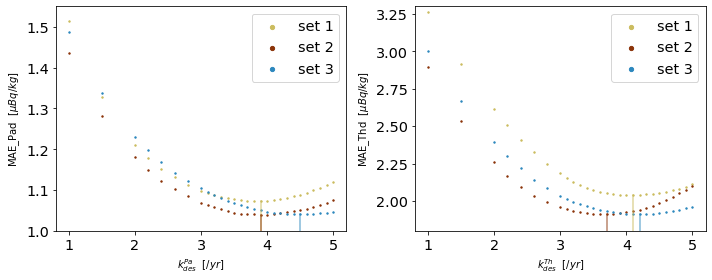

In [ ]:
# plot MAE vs kdes for ensemble KDE; version with 2 panels

########### SETTINGS #############################
var_y = 'MAE_unc_weights'  # can also select other MAE or RMSE columns from total_table (units, labels ready below)

units = {'PaThWs':'$[m/yr]$', 'XDesConst':'$[/yr]$', 'kads_sum_sigmas_x':'$[/yr]$', 'k_ads_x_sum':'$[/yr]$', 
         'sigmaXDu':'$[m^2/g~dust]$', 'sigmaXNeph':'$[m^2/g~neph]$', 'median':'$[\mu Bq/kg]$', 
         'MAE':'$[\mu Bq/kg]$', 'RMSE':'$[\mu Bq/kg]$', 'MAE_no_weights':'$[\mu Bq/kg]$',
         'MAE_tot_weights':'$[\mu Bq/kg]$', 'MAE_vol_weights':'$[\mu Bq/kg]$', 'MAE_unc_weights':'$[\mu Bq/kg]$'}
labels = {'PaThWs':'$w_s$', 'median':'median', 'MAE':'MAE', 'RMSE' : 'RMSE', 'MAE_no_weights' : 'MAE',
          'MAE_tot_weights':'MAE','MAE_unc_weights':'MAE','MAE_vol_weights':'MAE',
          'PaDesConst':'$k_{des}^{Pa}$', 'kads_sum_sigmas_pa':'$\sum_i \sigma_i^{Pa}$', 
          'k_ads_pa_sum':'$k_{ads,sum}^{Pa}$', 
          'sigmaPaDu':'$\sigma^{Pa}_{du}$', 'sigmaPaNeph':'$\sigma^{Pa}_{ne}$', 
          'ThDesConst':'$k_{des}^{Th}$', 'kads_sum_sigmas_th':'$\sum_i \sigma_i^{Th}$', 
          'k_ads_th_sum':'$k_{ads,sum}^{Th}$', 
          'sigmaThDu':'$\sigma^{Th}_{du}$', 'sigmaThNeph':'$\sigma^{Th}_{ne}$'}

colours = {'batch 1' : cmcr.roma([0.05]), 'batch 2': cmcr.roma([0.35]), 'batch 3': cmcr.roma([0.8])}  
# colours = {'batch 1' : cmcr.imola([0]), 'batch 2': cmcr.imola([0.5]), 'batch 3': cmcr.imola([0.8])}  # alternative, also colour-blind friendly
legend_labels = {'batch 1': 'set 2', 'batch 2': 'set 1', 'batch 3': 'set 3'}
# parameter set 1 has Ws=1000m/yr with sigmaPaPOC=0.02 etc; set 2 and 3 have 1400m/yr resp. 1600m/yr with both sigmaPaPOC=0.021 etc
runs_subset = {'batch 1': kdes_runs_batch1, 'batch 2': kdes_runs_batch2, 'batch 3': kdes_runs_batch3}

show_vert_lines = True
size = 2
# set ylimits
ymins = np.asarray([1.0, 1.8])
ymaxs = np.asarray([1.55, 3.3])
###################################################
assert ensemble == 'KDE', "Needs ensemble 'KDE' for this figure."

fig, ax = plt.subplots(1,2, figsize=(10,4))

## X is replaced below by Pa resp. Th; x is replaced below by pa resp. th
var_x = 'XDesConst'

for n,j in enumerate(['Pad','Thd']):
    if j[0:2] == 'Pa':
        this_var_x = var_x.replace('X','Pa').replace('x','pa')
    elif j[0:2] == 'Th':
        this_var_x = var_x.replace('X','Th').replace('x','th')
        
    if show_vert_lines:
        # trick to be able to get the vertical line all the way to bottom (on top of margin seems not possible):
        # set vertical margins to 0 and manually set axis such that enough space
        ax[n].margins(0.05,0.0)
        ax[n].set_ylim(ymins[n], ymaxs[n])
        
    for batch_name in ['batch 2', 'batch 1', 'batch 3']:
        table_subset = total_table[total_table.run_ID.isin(np.asarray(runs_subset[batch_name])+1000)]
        ax[n].scatter(table_subset[this_var_x], table_subset[var_y + '_' + j], s=size, color=colours[batch_name], label=legend_labels[batch_name])
        # print minimum value
        y_obj = table_subset.loc[:,('runname', this_var_x, var_y+'_'+j)]
        res = y_obj[y_obj[var_y+'_'+j] == y_obj[var_y+'_'+j].min()].dropna(how='all')
        best_kdes = res[this_var_x].item()
        print('Best kdes for '+batch_name+' ('+legend_labels[batch_name]+') for j=', j, ' :', best_kdes, '/yr, in run', res.runname.item())
        if show_vert_lines and n!=3:
            ax[n].plot([best_kdes, best_kdes], [ymins[n], res[var_y+'_'+j].item()], color=colours[batch_name], alpha=0.6)  # half lines
    
    ax[n].set_xlabel(labels[this_var_x] + '  ' + units[var_x])
    ax[n].set_ylabel(labels[var_y] + '_' + j + '  ' + units[var_y])
    # ax[n].set_title(j)
    
ax[0].legend(loc='upper right', markerscale=3)
ax[1].legend(loc='upper right', markerscale=3)

print('\n')
plt.tight_layout()
plt.savefig(savedir / ('figS2_' + ensemble + '_kdes_conclusion_2panels.pdf'))

In [18]:
# show parameter sets for a certain batch 
assert ensemble == 'KDE', "Needs ensemble 'KDE' for this figure."
batch_name = 'batch 2'  # set to 'batch 1' or 'batch 2' or 'batch 3'
total_table[total_table.run_ID == runs_subset[batch_name][0]+1000].loc[:,('runname','PaThWs','sigmaPaPOC', 'sigmaPaCa', 'sigmaPaOp', 'sigmaPaDu', 
                                                                          'sigmaPaNeph', 'sigmaThPOC', 'sigmaThCa', 'sigmaThOp', 'sigmaThDu', 'sigmaThNeph')]

,runname,PaThWs,sigmaPaPOC,sigmaPaCa,sigmaPaOp,sigmaPaDu,sigmaPaNeph,sigmaThPOC,sigmaThCa,sigmaThOp,sigmaThDu,sigmaThNeph
20,KDE1020_PI,1000,0.02,0.23,0.22,0.0044,0.028,0.084,3.97,0.11,0.0023,0.028


Best kdes for batch 2 (set 1) for j= Pad  : 3.9 /yr, in run KDE1036_PI
Best kdes for batch 1 (set 2) for j= Pad  : 3.9 /yr, in run KDE1019_PI
Best kdes for batch 3 (set 3) for j= Pad  : 4.5 /yr, in run KDE1078_PI
Best kdes for batch 2 (set 1) for j= Thd  : 4.1 /yr, in run KDE1048_PI
Best kdes for batch 1 (set 2) for j= Thd  : 3.7 /yr, in run KDE1018_PI
Best kdes for batch 3 (set 3) for j= Thd  : 4.2 /yr, in run KDE1075_PI
Best kdes for batch 2 (set 1) for j= Pap  : 5.0 /yr, in run KDE1039_PI
Best kdes for batch 1 (set 2) for j= Pap  : 5.0 /yr, in run KDE1014_PI
Best kdes for batch 3 (set 3) for j= Pap  : 4.0 /yr, in run KDE1073_PI
Best kdes for batch 2 (set 1) for j= Thp  : 4.4 /yr, in run KDE1051_PI
Best kdes for batch 1 (set 2) for j= Thp  : 5.0 /yr, in run KDE1014_PI
Best kdes for batch 3 (set 3) for j= Thp  : 5.0 /yr, in run KDE1083_PI




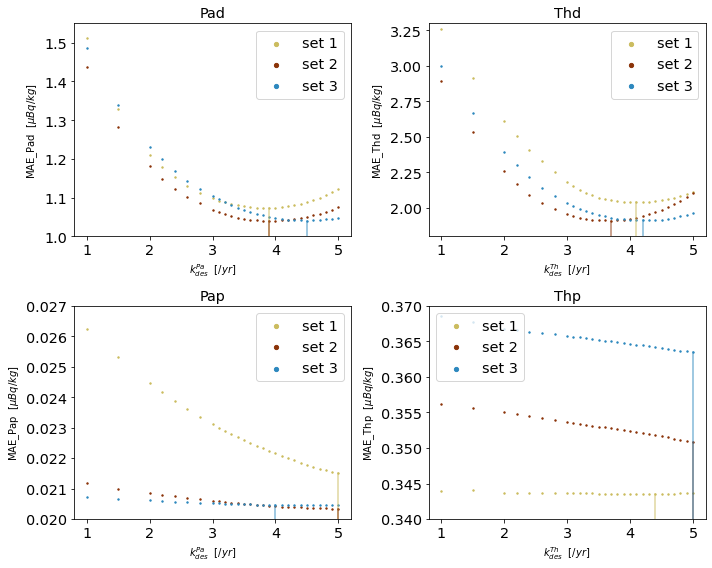

In [59]:
# plot MAE vs kdes for ensemble KDE; version with 4 panels

########### SETTINGS #############################
var_y = 'MAE_unc_weights'  # can also select other MAE or RMSE columns from total_table (units, labels ready below)

units = {'PaThWs':'$[m/yr]$', 'XDesConst':'$[/yr]$', 'kads_sum_sigmas_x':'$[/yr]$', 'k_ads_x_sum':'$[/yr]$', 
         'sigmaXDu':'$[m^2/g~dust]$', 'sigmaXNeph':'$[m^2/g~neph]$', 'median':'$[\mu Bq/kg]$', 
         'MAE':'$[\mu Bq/kg]$', 'RMSE':'$[\mu Bq/kg]$', 'MAE_no_weights':'$[\mu Bq/kg]$',
         'MAE_tot_weights':'$[\mu Bq/kg]$', 'MAE_vol_weights':'$[\mu Bq/kg]$', 'MAE_unc_weights':'$[\mu Bq/kg]$'}
labels = {'PaThWs':'$w_s$', 'median':'median', 'MAE':'MAE', 'RMSE' : 'RMSE', 'MAE_no_weights' : 'MAE',
          'MAE_tot_weights':'MAE','MAE_unc_weights':'MAE','MAE_vol_weights':'MAE',
          'PaDesConst':'$k_{des}^{Pa}$', 'kads_sum_sigmas_pa':'$\sum_i \sigma_i^{Pa}$', 
          'k_ads_pa_sum':'$k_{ads,sum}^{Pa}$', 
          'sigmaPaDu':'$\sigma^{Pa}_{du}$', 'sigmaPaNeph':'$\sigma^{Pa}_{ne}$', 
          'ThDesConst':'$k_{des}^{Th}$', 'kads_sum_sigmas_th':'$\sum_i \sigma_i^{Th}$', 
          'k_ads_th_sum':'$k_{ads,sum}^{Th}$', 
          'sigmaThDu':'$\sigma^{Th}_{du}$', 'sigmaThNeph':'$\sigma^{Th}_{ne}$'}

colours = {'batch 1' : cmcr.roma([0.05]), 'batch 2': cmcr.roma([0.35]), 'batch 3': cmcr.roma([0.8])}
# colours = {'batch 1' : cmcr.imola([0]), 'batch 2': cmcr.imola([0.5]), 'batch 3': cmcr.imola([0.8])}  # alternative, also colour-blind friendly
legend_labels = {'batch 1': 'set 2', 'batch 2': 'set 1', 'batch 3': 'set 3'}
# parameter set 1 has Ws=1000m/yr with sigmaPaPOC=0.02 etc; set 2&3 have 1400m/yr resp. 1600m/yr with sigmaPaPOC=0.021 etc
runs_subset = {'batch 1': kdes_runs_batch1, 'batch 2': kdes_runs_batch2, 'batch 3': kdes_runs_batch3}

show_vert_lines = True
size = 2
# set ylimits in all 4 subplots
ymins = np.asarray([[1.0, 1.8], [0.02,0.34]])
ymaxs = np.asarray([[1.55, 3.3], [0.027,0.37]])
###################################################
assert ensemble == 'KDE', "Needs ensemble 'KDE' for this figure."

fig, ax = plt.subplots(2,2, figsize=(10,8))

## X is replaced below by Pa resp. Th
var_x = 'XDesConst'

for n,j in enumerate(['Pad','Thd','Pap','Thp']):
    row = int(n/2)
    col = n%2
    if j[0:2] == 'Pa':
        this_var_x = var_x.replace('X','Pa').replace('x','pa')
    elif j[0:2] == 'Th':
        this_var_x = var_x.replace('X','Th').replace('x','th')

    if show_vert_lines:
        # trick to be able to get the vertical line all the way to bottom (on top of margin seems not possible):
        # set vertical margins to 0 and manually set axis such that enough space
        ax[row,col].margins(0.05,0.0)
        ax[row,col].set_ylim(ymins[row,col], ymaxs[row,col])

    for batch_name in ['batch 2', 'batch 1', 'batch 3']:
        table_subset = total_table[total_table.run_ID.isin(np.asarray(runs_subset[batch_name])+1000)]
        ax[row,col].scatter(table_subset[this_var_x], table_subset[var_y + '_' + j], s=size, color=colours[batch_name], label=legend_labels[batch_name])
        # print minimum value
        y_obj = table_subset.loc[:,('runname', this_var_x, var_y+'_'+j)]
        res = y_obj[y_obj[var_y+'_'+j] == y_obj[var_y+'_'+j].min()].dropna(how='all')
        best_kdes = res[this_var_x].item()
        print('Best kdes for '+batch_name+' ('+legend_labels[batch_name]+') for j=', j, ' :', best_kdes, '/yr, in run', res.runname.item())
        if show_vert_lines:# and n!=3:
            ax[row,col].plot([best_kdes, best_kdes], [ymins[row,col], res[var_y+'_'+j].item()], color=colours[batch_name], alpha=0.6)  # half lines
        
    ax[row,col].set_xlabel(labels[this_var_x] + '  ' + units[var_x])
    ax[row,col].set_ylabel(labels[var_y] + '_' + j + '  ' + units[var_y])
    ax[row,col].set_title(j)
        
    ax[row,col].legend(markerscale=3)
    
print('\n')
plt.tight_layout()
plt.savefig(savedir / (ensemble + '_kdes_conclusion_4panels.pdf'))

<a id='all'></a>
## Fig. S3,S4: determine best sigmas  
## => uses ensemble '3P5'  

[go to top](#top)

In [20]:
# READ IN csv made in tuning_find_best_fit.ipynb FOR THIS ENSEMBLE
ensemble = '3P5'  # do not change
total_table = pd.read_csv(savedir / ('total_table_ensemble_' + ensemble + '.csv'))

m=10
best runname for Pa: 3P52849_PI   at position Pad 7 and position Pap 148
best runname for Th: 3P52678_PI   at position Thd 7 and position Thp 486




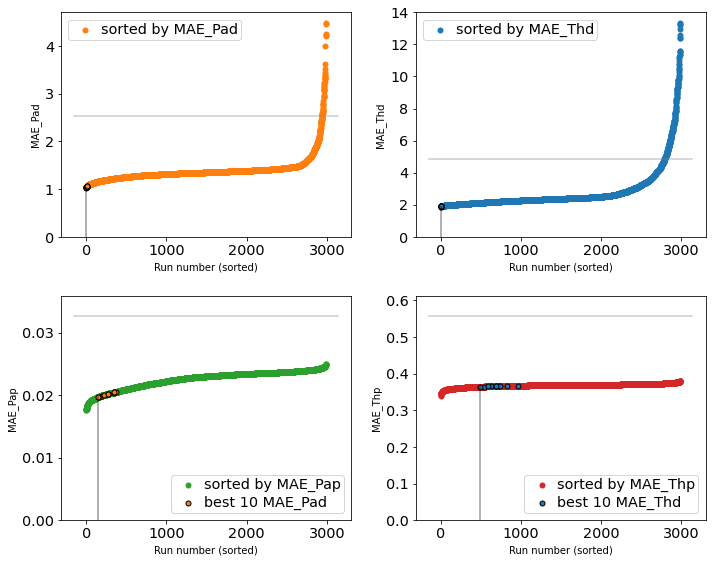

In [21]:
# plot of skill sorted

## SETTINGS ##############################

## choose one of the given skill columns of total_table; automatically takes Pa and Th variants
y_var = 'MAE_unc_weights' # final decision

size = 25  # marker size
colours = {'Pad' : 'C1', 'Thd' : 'C0', 'Pap' : 'C2', 'Thp' : 'C3', 'Pa' : 'orange', 'Th' : 'grey'}
filled = {'Pad' : True, 'Thd' : True, 'Pap' : True, 'Thp' : True, 'Pa' : True, 'Th' : True}
markers = {'Pad' : 'o', 'Thd' : 'o', 'Pap' : 'o', 'Thp' : 'o', 'Pa' : '*', 'Th' : '*'}
color_best_m = True  # mark best m runs with other markers
if color_best_m:
    m = 10

hor_lines = True   # adds 0 lines
vert_lines = True  # indicates result

# zoom by selecting a subset
no_outliers = True  # dont plot 10 highest vals in order to see the shape

# zoom settings used if show_vert_lines (no_outliers options break down)
ymins = np.asarray([[0.85,1.3],[0.017,0.337]])
ymaxs = np.asarray([[4.7,14],[0.0255,0.382]])

## END OF SETTINGS #######################
assert ensemble == '3P5', "Needs ensemble '3P5' for this figure."

print('m='+str(m))

if y_var[0:3] == 'MAE':
    score_type = 'MAE'
elif y_var[0:4] == 'RMSE':
    score_type = 'RMSE'
elif y_var == 'median':
    score_type = 'median'

fig, ax = plt.subplots(2,2, figsize=(10,8))

y_plot_vars = {'Pad' : y_var+'_Pad', 'Thd' : y_var+'_Thd', 
               'Pap' : y_var+'_Pap', 'Thp' : y_var+'_Thp'}
# legend_labels = {'Pad' : '$Pa_d$', 'Thd' : '$Th_d$',
#                  'Pap' : '$Pa_p$', 'Thp' : '$Th_p$'}

# first create all overal plot objects, s.t. can pick best 5 of all already in next loop (in case color_best_m):
y_plot_obj = {}
best_m_runs = {}
best_runname = {}
for j in y_plot_vars:  # loops over j='Pa' etc or 'Pad' etc
    y_plot_obj[j] = total_table.loc[:,('runname',y_plot_vars[j])].sort_values(y_plot_vars[j])
    y_plot_obj[j].insert(0,'new_id',range(len(y_plot_obj[j])))
    y_plot_obj[j].set_index('new_id', inplace=True)
    # y_plot_obj[j].sort_index(inplace=True)  # normally always need to sort after setting index, but now sorted by def    
    if color_best_m:
        best_m_runs[j] = y_plot_obj[j][0:m].runname # save best m runs (plot later again with other markers)

    if no_outliers:
        y_plot_obj[j] = y_plot_obj[j][0:-10]
    
for n,j in enumerate(y_plot_vars):   # loops over j='Pad' etc
    row = int(n/2)
    col = n%2
    if filled[j]: # filled markers
        fc = colours[j]
        ec = colours[j]  # such that equal size
    else: # plot open markers
        fc = 'none'
        ec = colours[j]
        
    ## plot function itself
    if color_best_m and j[2]=='d':
        # others without edge
        ax[row,col].scatter(y_plot_obj[j].index[m:], y_plot_obj[j][y_plot_vars[j]][m:], marker=markers[j], 
                            facecolors=fc, edgecolors=ec, s=size, label='sorted by MAE_' + j)  #label=j)        
        # plot first m with a black markeredge; no legend label
        ax[row,col].scatter(y_plot_obj[j].index[0:m], y_plot_obj[j][y_plot_vars[j]][0:m], marker=markers[j], 
                            facecolors=fc, edgecolors='k', s=size)
    else:
        ax[row,col].scatter(y_plot_obj[j].index, y_plot_obj[j][y_plot_vars[j]], marker=markers[j], 
                            facecolors=fc, edgecolors=ec, s=size, label='sorted by MAE_' + j)  #label=j)
    
    ## draw lines and appropriate smart y limit
    if hor_lines:
    # for median we add lines with obs. median; 
    # for RMSE/MAE we add line what RMSE/MAE would be in case of 0s everywhere
        if y_var == 'median':
            ax[row,col] = f.add_line(ax[row,col], median_obs[j], alpha=0.4)
        elif y_var in RMSE_tasks:
            y_0_line = RMSE0s[y_var][j]
            ax[row,col] = f.add_line(ax[row,col], y_0_line, alpha=0.4)
        elif y_var.replace('MAE','RMSE') in RMSE_tasks:
            y_0_line = MAE0s[y_var][j]
            ax[row,col] = f.add_line(ax[row,col], y_0_line, alpha=0.4)
    if vert_lines:
        # trick to be able to get the vertical line all the way to bottom (on top of margin seems not possible):
        # set vertical margins to 0 and manually set axis such that enough space
        ax[row,col].margins(0.05,0.0)

    if hor_lines and y_var != 'median':  # for median we don't adjust ylimits
        ax[row,col].set_ylim(0, max(ymaxs[row,col], y_0_line*1.1))
    elif vert_lines:
        # only vert_lines, no hor_lines:  as input boundaries in settings
        ax[row,col].set_ylim(ymins[row,col], ymaxs[row,col])       
    
    ## add dots of other in plot: only meaningful to add Pad to Pap etc; a strict boundary between Pa and Th results
    if color_best_m:
        if j[-1] == 'p':
            other_j = j[0:-1] + 'd'

            x_vals_other_j = [y_plot_obj[j][y_plot_obj[j].runname==run].index.values  # index 'new_id' contains the sorted index
                              for run in best_m_runs[other_j]]
            y_vals_other_j = [y_plot_obj[j][y_plot_obj[j].runname==run][y_plot_vars[j]].values
                              for run in best_m_runs[other_j]]
            # reshaping needed in case some are empty (namely if x axis object is cut by no_outliers or x_max)
            x_vals_other_j = np.asarray([x[0] for x in x_vals_other_j if len(x)>0])
            y_vals_other_j = np.asarray([y[0] for y in y_vals_other_j if len(y)>0])
            
            # print single best run conclusion
            position_p = x_vals_other_j.min()
            position_d = np.argmin(x_vals_other_j)
            best_runname[j[0:2]] = best_m_runs[other_j][position_d]
            print('best runname for '+j[0:2]+':', best_runname[j[0:2]], '  at position '+j[0:2]+'d', position_d, 'and position '+j[0:2]+'p', position_p)
            
            # indicate result with 1 vertical line
            if vert_lines:
                [ymin, ymax] = ax[row,col].get_ylim()
                ax[row,col].plot([position_p, position_p], [ymin, y_vals_other_j[position_d]], c='k', alpha=0.4)

            # plot best m dots
            ax[row,col].scatter(x_vals_other_j, y_vals_other_j, marker='o', 
                                # facecolors=colours[other_j], edgecolors=colours[other_j], s=size, label='best ' + str(m) + ' MAE_' + other_j)
                                facecolors=colours[other_j], edgecolors='k', s=size, label='best ' + str(m) + ' MAE_' + other_j)
        elif j[-1] == 'd':
            # only indicate result with 1 vertical line
            if vert_lines:
                [ymin, ymax] = ax[row,col].get_ylim()
                # instead of the best nr in 0-m we round this to run 0 because visually no difference if m << nr of runs
                ax[row,col].plot([0, 0], [ymin, y_plot_obj[j][y_var+'_'+j][0]], c='k', alpha=0.4)
            
    # ax[row,col].legend([legend_labels[j]], borderpad=0.2, handletextpad=0.1, labelspacing=0.3)  
    ax[row,col].legend(borderpad=0.2, handletextpad=0.1, labelspacing=0.3)
    # ax[row,col].legend(borderpad=0.2, handletextpad=0.1, labelspacing=0.3, loc='upper left', bbox_to_anchor=(0.05,0.9))
    ax[row,col].set_xlabel('Run number (sorted)\n')
    ax[row,col].set_ylabel(score_type + '_' + j)
        
print('\n') 
plt.tight_layout()
if no_outliers:
    plt.savefig(savedir / ('figS3_' + ensemble + '_' + y_var + '_sorted_wo10highest.pdf'))
else:
    plt.savefig(savedir / (ensemble + '_' + y_var + '_sorted_all.pdf'))

In [22]:
## Largest 10 values are excluded, which go up to MAE_Pad=10.7 MAE_Thd=18.6 (and in view: MAE_Pap=0.0253 MAE_Thp=0.3828)
## can be seen from printing:
# j = 'Thd'
# total_table.sort_values(y_var + '_' + j).loc[:, y_var + '_' + j]

In [23]:
# best parameters for Pa:
assert ensemble == '3P5', "Needs ensemble '3P5'."
total_table[total_table.runname == best_runname['Pa']]

,run_ID,runname,MRT_Pa,MRT_Th,median_Pad,median_Thd,median_Pap,median_Thp,MAE_no_weights_Pad,MAE_no_weights_Thd,...,sigmaPaPOC,sigmaPaCa,sigmaPaOp,sigmaPaDu,sigmaPaNeph,sigmaThPOC,sigmaThCa,sigmaThOp,sigmaThDu,sigmaThNeph
1849,2849,3P52849_PI,119.480012,46.666843,2.265555,7.97352,0.020813,0.219634,1.437627,4.563556,...,0.043466,0.058117,0.148937,0.003052,0.029345,0.195149,0.097606,0.185348,0.04792,0.109687


In [24]:
# best parameters for Th:
assert ensemble == '3P5', "Needs ensemble '3P5'."
total_table[total_table.runname == best_runname['Th']]

,run_ID,runname,MRT_Pa,MRT_Th,median_Pad,median_Thd,median_Pap,median_Thp,MAE_no_weights_Pad,MAE_no_weights_Thd,...,sigmaPaPOC,sigmaPaCa,sigmaPaOp,sigmaPaDu,sigmaPaNeph,sigmaThPOC,sigmaThCa,sigmaThOp,sigmaThDu,sigmaThNeph
1678,2678,3P52678_PI,100.334754,27.616041,1.872572,4.668916,0.020945,0.210838,1.70228,2.947294,...,0.040926,0.057509,0.123345,0.017054,0.019865,0.089585,1.829473,0.082235,0.011149,0.06362


y_var:  MAE_unc_weights


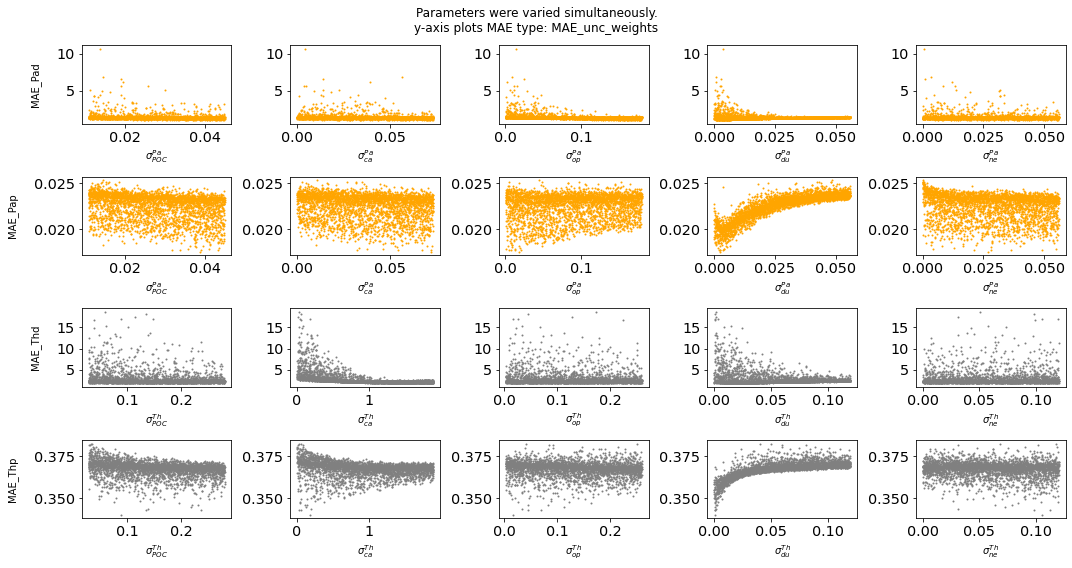

In [25]:
# ALL SIGMAS COMBINED IN 5X4 SUBPLOTS: plot skill/variable (choose) per parameter

## SETTINGS ##############################

## choose one of the MAE or RMSE scores in total_table; automatically takes Pa and Th variants
y_var = 'MAE_unc_weights'  # final choice
# y_var = 'RMSE_all'
# y_var = 'MAE_noArctic'

small_file = True           # reduce file size by rasterizing dots; text and axes remain vector
log = False                 # make plot logarithmic
grey_sigma_ranges = False   # observational/literature ranges of sigmas as grey rectangles
hor_lines = False           # 0 lines of MAE/RMSE
size = 1
x_units = False
y_units = False
color_variable = False      
if color_variable:
    c_var = 'median'
    alpha_c = 0.5           # now it becomes relevant to see if multiple circles overlap
else:
    colors = {'Pad' : 'orange', 'Pap' : 'orange', 'Thd' : 'grey', 'Thp' : 'grey'}

zoom = False
# settings for zoom:
# not set correctly yet
Pamin = 0.02
Pamax = 0.032
Thmin = 0.465
Thmax = 0.485
# xmin = 0
# xmax = 5

## END OF SETTINGS #######################
assert ensemble == '3P5', "Needs ensemble '3P5' for this figure."

## ADMINISTRATION OF LABELS AND VAR NAMES
# x axis var names (correspond to column names of total_table):
x_vars_pa = ['sigmaPaPOC', 'sigmaPaCa', 'sigmaPaOp','sigmaPaDu', 'sigmaPaNeph']
x_vars_th = ['sigmaThPOC', 'sigmaThCa', 'sigmaThOp', 'sigmaThDu', 'sigmaThNeph']
if x_units:  # needs to be in same order
    x_vars_units = ['\n[m2/mol C]', '\n[m2/mol C]', '\n[m2/mol Si]', '\n[m2/g dust]', '\n[m2/g neph]']
else:
    x_vars_units = [''] * len(x_vars_pa)
x_labels_pa = ['$\sigma^{Pa}_{POC}$', '$\sigma^{Pa}_{ca}$', '$\sigma^{Pa}_{op}$', '$\sigma^{Pa}_{du}$', '$\sigma^{Pa}_{ne}$']
x_labels_th = ['$\sigma^{Th}_{POC}$', '$\sigma^{Th}_{ca}$', '$\sigma^{Th}_{op}$', '$\sigma^{Th}_{du}$', '$\sigma^{Th}_{ne}$']   

# y-axis hardcoded namings, units and shorthands:
ylabel = y_var
if y_var[0:4] == 'RMSE':
    y_unit = '\n[uBq/kg]'
    ylabel = 'RMSE' # overwrite ylabel with a shorthand
elif y_var[0:3] == 'MAE':
    y_unit = '\n[uBq/kg]'
    ylabel = 'MAE' # overwrite ylabel with a shorthand
else:
    raise Exception("y_var" + y_var + "unknown or not implemented yet.")
print('y_var: ', y_var)
if not y_units:
    y_unit = ''

## PLOTTING
fig, ax = plt.subplots(4,5, figsize=(15,8))

# construct a clear title of what is going on:
how_varied = "simultaneously"
if y_var[0:4] == 'RMSE':
    explain_yaxis = "\ny-axis plots RMSE type: " + y_var
elif y_var[0:3] == 'MAE':
    explain_yaxis = "\ny-axis plots MAE type: " + y_var
else:
    explain_yaxis = ""
fig.suptitle("Parameters were varied " + how_varied + "." + explain_yaxis)

# plotting: rows: Pad Pap Thd Thp; columns: 5x sigmas
for col in range(5):
    x_var_nr = col
    table_subset = total_table
        
    # Pad, Pap (row 1 and 2)
    for n,j in enumerate(['Pad', 'Pap']):
        row = n
        if color_variable:
            cpf = ax[row,col].scatter(table_subset[x_vars_pa[x_var_nr]], table_subset[y_var + '_' + j], 
                                      c=table_subset[c_var + '_' + j], s=size, alpha=alpha_c, rasterized=small_file)
            fig.colorbar(cpf, ax=ax[row,col])
        else:
            ax[row,col].scatter(table_subset[x_vars_pa[x_var_nr]], table_subset[y_var + '_' + j], 
                                c=colors[j], s=size, rasterized=small_file)
        # labels, limits and lines
        ax[row,col].set_xlabel(x_labels_pa[x_var_nr] + x_vars_units[x_var_nr])
        if zoom:
            ax[row,col].set_ylim(Pamin, Pamax)
            # ax[row,col].set_xlim(xmin, xmax)
        if log:
            ax[row,col].set_xscale('log')
            ax[row,col].set_yscale('log')
        if hor_lines:
            if y_var in RMSE0s:
                ax[row,col] = f.add_line(ax[row,col], RMSE0s[y_var][j], c='grey', alpha=0.4)
            elif y_var in MAE0s:
                ax[row,col] = f.add_line(ax[row,col], MAE0s[y_var][j], c='grey', alpha=0.4)

    # Thd, Thp (row 3 and 4)
    for n,j in enumerate(['Thd', 'Thp']):
        row = n + 2
        if color_variable:
            cpf = ax[row,col].scatter(table_subset[x_vars_th[x_var_nr]], table_subset[y_var + '_' + j], 
                                      c=table_subset[c_var + '_' + j], s=size, alpha=alpha_c, rasterized=small_file)
            fig.colorbar(cpf, ax=ax[row,col])
        else:
            ax[row,col].scatter(table_subset[x_vars_th[x_var_nr]], table_subset[y_var + '_' + j], 
                                c=colors[j], s=size, rasterized=small_file)
        
        # labels, limits and lines
        ax[row,col].set_xlabel(x_labels_th[x_var_nr] + x_vars_units[x_var_nr])
        if zoom:
            ax[row,col].set_ylim(Thmin, Thmax)
            # ax[row,col].set_xlim(xmin, xmax)
        if log:
            ax[row,col].set_xscale('log')
            ax[row,col].set_yscale('log')
        if hor_lines:
            if y_var in RMSE0s:
                ax[row,col] = f.add_line(ax[row,col], RMSE0s[y_var][j], c='grey', alpha=0.4)
            elif y_var in MAE0s:
                ax[row,col] = f.add_line(ax[row,col], MAE0s[y_var][j], c='grey', alpha=0.4)
                
ax[0,0].set_ylabel(ylabel+'_Pad'+y_unit+'\n')
ax[1,0].set_ylabel(ylabel+'_Pap'+y_unit+'\n')
ax[2,0].set_ylabel(ylabel+'_Thd'+y_unit+'\n')
ax[3,0].set_ylabel(ylabel+'_Thp'+y_unit+'\n')

## PLOTTING GADGETS
if grey_sigma_ranges:
    alpha_sigmas = 0.1
    for row in [0,1]: # Pa
        ax[row,0] = f.add_rectangle(ax[row,0], x_bnds=bnd_sigma_pa_poc, alpha=alpha_sigmas)        
        ax[row,1] = f.add_rectangle(ax[row,1], x_bnds=bnd_sigma_pa_ca, alpha=alpha_sigmas)
        ax[row,2] = f.add_rectangle(ax[row,2], x_bnds=bnd_sigma_pa_op, alpha=alpha_sigmas)
        ax[row,3] = f.add_rectangle(ax[row,3], x_bnds=bnd_sigma_pa_du, alpha=alpha_sigmas)
        ax[row,4] = f.add_rectangle(ax[row,4], x_bnds=bnd_sigma_pa_ne, alpha=alpha_sigmas)        
    for row in [2,3]: # Th
        ax[row,0] = f.add_rectangle(ax[row,0], x_bnds=bnd_sigma_th_poc, alpha=alpha_sigmas)
        ax[row,1] = f.add_rectangle(ax[row,1], x_bnds=bnd_sigma_th_ca, alpha=alpha_sigmas)
        ax[row,2] = f.add_rectangle(ax[row,2], x_bnds=bnd_sigma_th_op, alpha=alpha_sigmas)
        ax[row,3] = f.add_rectangle(ax[row,3], x_bnds=bnd_sigma_th_du, alpha=alpha_sigmas)
        ax[row,4] = f.add_rectangle(ax[row,4], x_bnds=bnd_sigma_th_ne, alpha=alpha_sigmas)
    print('If rectangles of sigma boundaries are not plotted, then they are thinner than 1 pixel\n')

plt.tight_layout()

extra_info = ''
if log:
    extra_info += '_log'
if zoom:
    extra_info += '_zoom'

if small_file:
    plt.savefig(savedir / ('figS4_' + ensemble + '_' + y_var + '_per_all_sigmas' + extra_info + '.pdf'), dpi=400)
    # src: https://www.astrobetter.com/blog/2014/01/17/slim-down-your-bloated-graphics/ and a bit of
    # https://stackoverflow.com/questions/10685495/reducing-the-size-of-pdf-figure-file-in-matplotlib
else:
    # default becomes 0.94 MB and makes scrolling/loading slow
    plt.savefig(savedir / ('figS4_' + ensemble + '_' + y_var + '_per_all_sigmas' + extra_info + '_large.pdf'))